## Chapter 5: Resampling Methods - Applied Exercises

In [85]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly,
                         sklearn_sm)
from functools import partial
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     LeaveOneOut,
                                     KFold,
                                     ShuffleSplit)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, mean_squared_error

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

Fit a logistic regression model that uses `income` and `balance` to predict `default`.

In [2]:
Default = load_data('default')

In [5]:
Default_train, Default_valid = train_test_split(Default, test_size=5000, random_state=0)

In [14]:
# Fit a linear regression using the training set
default_mm = MS(['income', 'balance'])
X_train = default_mm.fit_transform(Default_train)
y_train = Default_train['default'] == 'Yes'
model = sm.Logit(y_train, X_train)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 10


In [18]:
# Perform predictions on validation set
X_valid = default_mm.transform(Default_valid)
y_valid = Default_valid['default'] == 'Yes'
valid_pred = results.predict(X_valid)

# Overall fraction of misclassified observations
1 - np.mean(y_valid == (valid_pred > 0.5))

0.029000000000000026

In [16]:
valid_pred

9394    0.000014
898     0.000247
2398    0.008043
5906    0.002046
2343    0.000298
          ...   
3996    0.001859
5889    0.000034
4577    0.008793
8600    0.000735
847     0.000131
Length: 5000, dtype: float64

Repeat the process three times, using three diferent splits of the observations into a training set and a validation set. Comment on the results obtained.

In [20]:
# Create a vector to store the confusion matrices for the splits
C = []

In [23]:
for i in range(1,4):
    Default_train, Default_valid = train_test_split(Default, test_size=5000)
    X_train = default_mm.fit_transform(Default_train)
    y_train = Default_train['default'] == 'Yes'
    model = sm.Logit(y_train, X_train)
    results = model.fit()

    X_valid = default_mm.transform(Default_valid)
    y_valid = Default_valid['default'] == 'Yes'
    valid_pred = results.predict(X_valid)

    C.append(confusion_matrix(valid_pred > 0.5, y_valid))

Optimization terminated successfully.
         Current function value: 0.078193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078611
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.073792
         Iterations 10


In [24]:
tpr, fpr, ppv, npv, acc = ([] for i in range(5))

for c in C:
    tn = c[0,0] 
    fp = c[0,1]
    fn = c[1,0]
    tp = c[1,1]
    tpr.append((tp / (tp + fn + 0.)))
    fpr.append((fp / (fp + tn + 0.)))
    ppv.append((tp / (tp + fp + 0.)))
    npv.append((1- f n / (fn + tn + 0.)))
    acc.append(((tp + tn + 0.) / (tn + fp + fn + tp)))

In [25]:
def line(l):
    return " ".join( '{:06.4f}'.format(a) for a in l) + ', Average: ' +'{:06.4f}'.format(sum(l)/ len(l))

print('TPR: ')
print(line(tpr))
print('FPR: ')
print(line(fpr))
print('PPV: ')
print(line(ppv))
print('NPV: ')
print(line(npv))
print('ACC: ')
print(line(acc))

TPR: 
0.7432 0.8060 0.6471, Average: 0.7321
FPR: 
0.0229 0.0259 0.0248, Average: 0.0246
PPV: 
0.3274 0.2967 0.3107, Average: 0.3116
NPV: 
0.9961 0.9973 0.9938, Average: 0.9957
ACC: 
0.9736 0.9718 0.9696, Average: 0.9717


Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [26]:
Default_train, Default_valid = train_test_split(Default, test_size=5000, random_state=0)

In [36]:
Default_train['student_yes'] = (Default_train['student'] == 'Yes').astype('int')
Default_valid['student_yes'] = (Default_valid['student'] == 'Yes').astype('int')
Default_train['default_yes'] = (Default_train['default'] == 'Yes').astype('int')
Default_valid['default_yes'] = (Default_valid['default'] == 'Yes').astype('int')

In [37]:
# Fit a linear regression using the training set
default_mm = MS(['income', 'balance', 'student_yes'])
X_train = default_mm.fit_transform(Default_train)
y_train = Default_train['default_yes']
model = sm.Logit(y_train, X_train)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.072293
         Iterations 10


In [38]:
# Perform predictions on validation set
X_valid = default_mm.transform(Default_valid)
y_valid = Default_valid['default_yes']
valid_pred = results.predict(X_valid)

# Overall fraction of misclassified observations
1 - np.mean(y_valid == (valid_pred > 0.5))

0.029200000000000004

It seems that adding the dummy student variable doesn't help with validation error rate, in fact, it makes it slightly worse.

We continue to consider the use of a logistic regression model to predict the probability of `default` using `income` and `balance` on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the `sm.GLM()` function. 

Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.

In [41]:
design = MS(['income', 'balance'])
X = design.fit_transform(Default)
# We are predicting whether Default is 'Yes'
y = Default['default'] == 'Yes'
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(summarize(results))

                coef   std err       z  P>|z|
intercept -11.540500  0.435000 -26.544    0.0
income      0.000021  0.000005   4.174    0.0
balance     0.005600  0.000000  24.835    0.0


Write a function, `boot_fn()`, that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for `income` and `balance` in the multiple logistic regression model.

In [55]:
def boot_fn(D, idx):
    model_matrix = MS(['income', 'balance'])
    D_ = D.loc[idx]
    Y_ = D_['default'] == 'Yes'
    X_ = clone(model_matrix).fit_transform(D_)
    results = sm.OLS(Y_, X_).fit()
    coef_income = results.params[1]
    coef_balance = results.params[2]
    return [coef_income, coef_balance]

Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression coefficients for income and balance.

In [58]:
# Calculate the coefficient values for 100 bootstrap samples
rng = np.random.default_rng(0)
coefficients = np.array([boot_fn(Default, rng.choice(1000, 10000, replace=True)) for _ in range(100)])

In [64]:
pd.DataFrame(coefficients).mean()

0    7.484588e-07
1    1.321718e-04
dtype: float64

9. We will now perform cross-validation on a simulated data set.

In [65]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

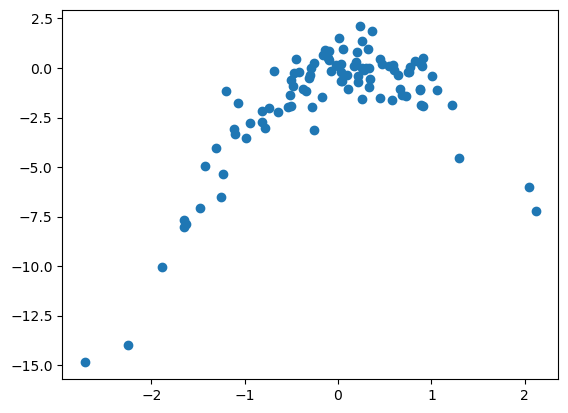

In [69]:
plt.scatter(x, y)
plt.show()

The scatterplot shows that y is a convex quadratic function of x.

Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i. $ Y = \beta_0 + \beta_1 X + \epsilon $

ii. $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon $ 

iii. $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon $

iv. $ Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \beta_4 X^4 + \epsilon $

In [70]:
# Set a new random seed
np.random.seed(5)

In [73]:
# Create a LOOCV object
loo = LeaveOneOut()

In [76]:
df = pd.DataFrame({'x': x, 'y': y})

In [90]:
def perform_polynomial_comparison(min_deg=1, max_deg=4):
    # Compute mean squared error (MSE) for the different polynomial equations
    for i in range(min_deg, max_deg + 1):
        scores = []
        
        # Leave-one-out cross validation 
        for train, test in loo.split(df):
            X_train = df['x'][train].values
            y_train = df['y'][train].values
            X_test = df['x'][test].values
            y_test = df['y'][test].values

            # Pipeline
            model = Pipeline([('poly', PolynomialFeatures(degree = i)),
                        ('linear', LinearRegression())])
            model.fit(X_train[:,np.newaxis], y_train)

            # MSE
            score = mean_squared_error(y_test, model.predict(X_test[:,np.newaxis]))
            scores.append(score)

        print('Model %i (MSE): %f' % (i,np.mean(scores)))

In [91]:
min_deg = 1  # Minimum degree of the polynomial equations considered
max_deg = 4  # Maximum degree of the polynomial equations considered

perform_polynomial_comparison(min_deg, max_deg)
    

Model 1 (MSE): 6.633030
Model 2 (MSE): 1.122937
Model 3 (MSE): 1.301797
Model 4 (MSE): 1.332394


Repeat using another random seed, and report your results. Are your results the same as what you got previously? Why?

In [92]:
# Set a new random seed
np.random.seed(10)

In [93]:
perform_polynomial_comparison(min_deg, max_deg)

Model 1 (MSE): 6.633030
Model 2 (MSE): 1.122937
Model 3 (MSE): 1.301797
Model 4 (MSE): 1.332394


The results are exactly the same because we only remove one observation from the training set on each validation. There is no random effect resulting from the observations used for the test set. LOOCV will always be the same, no matter the random seed.

The model that had the smallest LOOCV error was model (ii). This was an expected result because model (ii) has the same form as y (i.e. second order polynomial).

Comment on the statistical significance of the coefficient estimates that results from fitting each of the models using least squares. Do these results agree with the conclusions drawn
based on the cross-validation results?

In [97]:
# Models with polynomial features
min_deg = 1  
max_deg = 4 

for i in range(min_deg, max_deg + 1):
    pol = PolynomialFeatures(degree = i)
    X_pol = pol.fit_transform(df['x'].values[:,np.newaxis])
    y = df['y']

    model = sm.OLS(y, X_pol)
    results = model.fit()

    print(results.summary())  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           1.04e-09
Time:                        12:52:15   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650      0.247     -5.937      0.0

When we have a second order polynomial, both x1 and x2 have high t-statistic values. When we have a third order polynomial, x2 has the highest t-statistic, followed by x1 and then by x3. Finally, when we have a fourth order polynomial, x2 is the variable with the highest t-statistic, followed by x1, x4 and x3.

In all models in which it appears, x3 has a p-value > 0.05, meaning that we don't have sufficient evidence to conclude that this term has a significant effect on y.

We can conclude that x2 and x1 are variables with relevance for the presented models. These results agree with the conclusions drawn based on the cross-validation results, showing that the first and second order terms are the most significant.
